# 作業 : (Kaggle)鐵達尼生存預測
***
- 分數以網站評分結果為準, 請同學實際將提交檔(*.csv)上傳試試看  
https://www.kaggle.com/c/titanic/submit

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察觀查混合泛化 (Blending) 的寫法與效果

# [作業重點]
- 觀察混合泛化的準確度 (In[14]), 是否比單一模型準確度為高 (In[11~13])  
- 除了我們的權重, 同學也可以試著自行調整權重 (注意:權重和=1), 看看有什麼影響
- Hint : 除了權重, 分類預測的調整, 還可以調整什麼地方?

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy, time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

data_path = '../data/'
df_train = pd.read_csv(data_path + 'titanic_train.csv')
df_test = pd.read_csv(data_path + 'titanic_test.csv')

train_Y = df_train['Survived']
ids = df_test['PassengerId']
df_train = df_train.drop(['PassengerId', 'Survived'] , axis=1)
df_test = df_test.drop(['PassengerId'] , axis=1)
df = pd.concat([df_train,df_test])
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df)

,Missing Ratio
Cabin,77.463713
Age,20.091673
Embarked,0.152788
Fare,0.076394


In [3]:
df_orgin = pd.concat([df_train,df_test])
df_orgin.isnull().agg('sum').sort_values(ascending=False)

Cabin       1014
Age          263
Embarked       2
Fare           1
Ticket         0
Parch          0
SibSp          0
Sex            0
Name           0
Pclass         0
dtype: int64

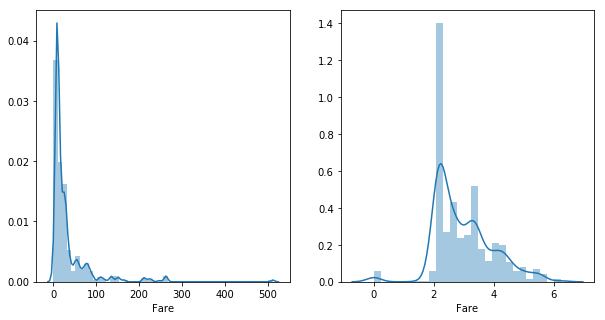

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.distplot(df_orgin['Fare'].fillna(value=0))
plt.subplot(122)
sns.distplot(np.log1p(df_orgin['Fare'].fillna(value=0)));

In [5]:
# 以下 In[3]~In[10] 只是鐵達尼預測中的一組特徵工程, 並以此組特徵工程跑參數, 若更換其他特徵工程, In[10]的參數需要重新跑
# Sex : 直接轉男 0 女 1
df["Sex"] = df["Sex"].map({"male": 0, "female":1})
# Fare : 用 log 去偏態, 0 則直接取 0
df["Fare"] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
# Age : 缺值用中位數補
df["Age"] = df["Age"].fillna(df['Age'].median())

In [9]:
df_orgin['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip()).value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Ms                2
Mlle              2
Capt              1
Jonkheer          1
Sir               1
Lady              1
the Countess      1
Dona              1
Don               1
Mme               1
Name: Name, dtype: int64

In [10]:
# Title 的 特徵工程 : 將各種頭銜按照類型分類, 最後取 One Hot
df_title = [i.split(",")[1].split(".")[0].strip() for i in df["Name"]]
df["Title"] = pd.Series(df_title)
df["Title"] = df["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df["Title"] = df["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
df["Title"] = df["Title"].astype(int)
df = pd.get_dummies(df, columns = ["Title"])

In [11]:
df_orgin[['SibSp', 'Parch']].describe()

,SibSp,Parch
count,1309.000000,1309.000000
mean,0.498854,0.385027
std,1.041658,0.865560
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,8.000000,9.000000


In [12]:
# 新建:家庭大小 (Fsize)特徵, 並依照大小分別建獨立欄位
df["Fsize"] = df["SibSp"] + df["Parch"] + 1
df['Single'] = df['Fsize'].map(lambda s: 1 if s == 1 else 0)
df['SmallF'] = df['Fsize'].map(lambda s: 1 if  s == 2  else 0)
df['MedF'] = df['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df['LargeF'] = df['Fsize'].map(lambda s: 1 if s >= 5 else 0)

In [13]:
df_orgin['Ticket'].head(50), df_orgin['Ticket'].dtypes, df_orgin['Ticket'].isnull().sum()

(0            A/5 21171
 1             PC 17599
 2     STON/O2. 3101282
 3               113803
 4               373450
 5               330877
 6                17463
 7               349909
 8               347742
 9               237736
 10             PP 9549
 11              113783
 12           A/5. 2151
 13              347082
 14              350406
 15              248706
 16              382652
 17              244373
 18              345763
 19                2649
 20              239865
 21              248698
 22              330923
 23              113788
 24              349909
 25              347077
 26                2631
 27               19950
 28              330959
 29              349216
 30            PC 17601
 31            PC 17569
 32              335677
 33          C.A. 24579
 34            PC 17604
 35              113789
 36                2677
 37          A./5. 2152
 38              345764
 39                2651
 40                7546
 41             

In [14]:
'C.A. 24579'.replace('.','').replace('/','').strip().split(' ')[0]

'CA'

In [15]:
df_orgin.Ticket.apply(lambda x: x.replace(".","").replace("/","").strip().split(' ')[0] if not x.isdigit() else 'X').value_counts()

X          957
PC          92
CA          68
A5          28
SOTONOQ     24
WC          15
STONO       14
SCPARIS     14
A4          10
FCC          9
C            8
SOC          8
STONO2       7
SOPP         7
SCParis      5
SCAH         5
LINE         4
PP           4
WEP          4
FC           3
SOTONO2      3
SCA4         2
SWPP         2
SC           2
PPP          2
AQ4          1
LP           1
CASOTON      1
A            1
AS           1
Fa           1
AQ3          1
SOP          1
STONOQ       1
SCA3         1
SP           1
SCOW         1
Name: Ticket, dtype: int64

In [16]:
# Ticket : 如果不只是數字-取第一個空白之前的字串(去除'.'與'/'), 如果只是數字-設為'X', 最後再取 One Hot
Ticket = []
for i in list(df.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")        
df["Ticket"] = Ticket
df = pd.get_dummies(df, columns = ["Ticket"], prefix="T")

In [17]:
df_orgin[pd.isnull(df_orgin['Cabin']).values!=True]['Cabin'].head(10)

1             C85
3            C123
6             E46
10             G6
11           C103
21            D56
23             A6
27    C23 C25 C27
31            B78
52            D33
Name: Cabin, dtype: object

In [18]:
df_orgin['Cabin'].apply(lambda x: x[0] if not pd.isnull(x) else 'X').value_counts()

X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

In [19]:
# Cabib 依照第一碼分類, 再取 One Hot
df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df['Cabin'] ])
df = pd.get_dummies(df, columns = ["Cabin"], prefix="Cabin")

In [20]:
print(df_orgin['Embarked'].value_counts(), df_orgin['Embarked'].isnull().sum())
print(df_orgin['Pclass'].value_counts(), df_orgin['Pclass'].isnull().sum())

S    914
C    270
Q    123
Name: Embarked, dtype: int64 2
3    709
1    323
2    277
Name: Pclass, dtype: int64 0


In [21]:
df_orgin['Pclass'].astype('category')[:5], df_orgin['Pclass'][:5]

(0    3
 1    1
 2    3
 3    1
 4    3
 Name: Pclass, dtype: category
 Categories (3, int64): [1, 2, 3], 0    3
 1    1
 2    3
 3    1
 4    3
 Name: Pclass, dtype: int64)

In [22]:
# Embarked, Pclass 取 One Hot
df = pd.get_dummies(df, columns = ["Embarked"], prefix="Em")
df["Pclass"] = df["Pclass"].astype("category")
df = pd.get_dummies(df, columns = ["Pclass"], prefix="Pc")

# 捨棄 Name 欄位
df.drop(labels = ["Name"], axis = 1, inplace = True)

In [23]:
# 確認缺值 與 目前的資料表內容
na_check(df)
df.head()

,Missing Ratio


,Sex,Age,SibSp,Parch,Fare,Title_0,Title_1,Title_2,Title_3,Fsize,...,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3
0,0,22.0,1,0,1.981001,0,0,1,0,2,...,0,0,0,1,0,0,1,0,0,1
1,1,38.0,1,0,4.266662,0,1,0,0,2,...,0,0,0,0,1,0,0,1,0,0
2,1,26.0,0,0,2.070022,0,1,0,0,1,...,0,0,0,1,0,0,1,0,0,1
3,1,35.0,1,0,3.972177,0,1,0,0,2,...,0,0,0,0,0,0,1,1,0,0
4,0,35.0,0,0,2.085672,0,0,1,0,1,...,0,0,0,1,0,0,1,0,0,1


In [24]:
# 將資料最大最小化
df = MinMaxScaler().fit_transform(df)

# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = df[:train_num]
test_X = df[train_num:]

# 使用三種模型 : 邏輯斯迴歸 / 梯度提升機 / 隨機森林, 參數使用 Random Search 尋找
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
lr = LogisticRegression(tol=0.001, penalty='l2', fit_intercept=True, C=1.0)
gdbt = GradientBoostingClassifier(tol=100, subsample=0.75, n_estimators=250, max_features=20,
                                  max_depth=6, learning_rate=0.03)
rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, 
                            max_features='sqrt', max_depth=6, bootstrap=True)

C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [25]:
# 線性迴歸預測檔 (結果有部分隨機, 請以 Kaggle 計算的得分為準, 以下模型同理)
lr.fit(train_X, train_Y)
lr_pred = lr.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'PassengerId': ids, 'Survived': lr_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_lr.csv', index=False) 

In [26]:
# 梯度提升機預測檔 
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'PassengerId': ids, 'Survived': gdbt_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_gdbt.csv', index=False)

In [27]:
# 隨機森林預測檔
rf.fit(train_X, train_Y)
rf_pred = rf.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'PassengerId': ids, 'Survived': rf_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_rf.csv', index=False)

# 作業
* 雖然同樣是混合泛化，分類預測其實與回歸預測有相當多的差異性，
因為鐵達尼預測的結果是 '生存/死亡'，輸出不是 0 就是 1  
因此要用權重混合時，需要以以機率的形式混合，因此我們在作業前幾格當中，先幫各位同學把預測值寫成了機率的形式  
(請同學把下列程式完成，並將結果提交到 Kaggle 網站看看結果)

* 但是光是這樣，分類問題的混合泛化就能比單模預測還要好嗎?  
已經快要期中考了，這裡請同學挑戰看看，還有沒有什麼方法可以改進混合泛化的結果?
- **Ans: 嘗試調整判斷生存機率的閾值由0.5>>0.7 提升倆的百分點**

In [28]:
kaggle_result = {'gdbt':0.67942, 'rf':0.66507, 'lr':0.66985}
weight = {key:value/sum(list(kaggle_result.values())) for key, value in zip(kaggle_result.keys(), kaggle_result.values())}
weight

{'gdbt': 0.3372916190911167,
 'rf': 0.3301676976081496,
 'lr': 0.3325406833007337}

In [31]:
# 混合泛化預測檔 
"""
Your Code Here
"""
blending_pred = lr_pred*0.34  + gdbt_pred*0.33 + rf_pred*0.33
sub = pd.DataFrame({'PassengerId': ids, 'Survived': blending_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.8 else 0)
sub.to_csv('titanic_blending_thres_80.csv', index=False)